In [213]:
%matplotlib inline
import matplotlib.pyplot
import numpy
import os
import math
import string
import json
import pandas
import scipy
import scipy.spatial
import tqdm
import networkx
import random
import sklearn.linear_model
import psycopg2
import configparser
import sqlalchemy
import umap
import seaborn

In [33]:
config = configparser.ConfigParser()
config.read('../db.conf')
dbname = config['database']['dbname']
user = config['database']['user']
password = config['database']['password']
host = config['database']['host']
port = config['database']['port']
conn = psycopg2.connect(f'dbname={dbname} user={user} password={password} host={host} port={port}')
read_cursor = conn.cursor()
stats_cursor = conn.cursor()

In [34]:
engine = sqlalchemy.create_engine(
    f"postgresql+psycopg2://{user}:{password}@{host}:5432/{dbname}")

In [186]:
language_names = pandas.read_sql("select * from wikidata_iso639_codes", engine)
language_name_lookup = language_names.set_index('iso_639_3_code').language_name.to_dict()

In [207]:
language_orthography = pandas.read_sql("select * from language_orthography", engine)
orthography_lookup = language_orthography.set_index('iso_639_3_code').best_tokenisation_method.to_dict()

In [200]:
#CORR_TO_USE = 'log_confidence_correlation'
CORR_TO_USE = 'confidence_spearman_correlation'

In [210]:
%%time
distances = pandas.read_sql(f"""
  select language1, language2, {CORR_TO_USE}, tokenisation_method_id
    from language_pairing_links join language_orthography as l1 on (language1 = l1.iso_639_3_code)
                                join language_orthography as l2 on (language2 = l2.iso_639_3_code)
   where l1.best_tokenisation_method = l2.best_tokenisation_method
     and l1.best_tokenisation_method = language_pairing_links.tokenisation_method_id
     and l2.best_tokenisation_method = language_pairing_links.tokenisation_method_id
  """, engine)

CPU times: user 4.99 s, sys: 1.44 s, total: 6.43 s
Wall time: 2min 54s


<AxesSubplot:xlabel='confidence_spearman_correlation', ylabel='Count'>

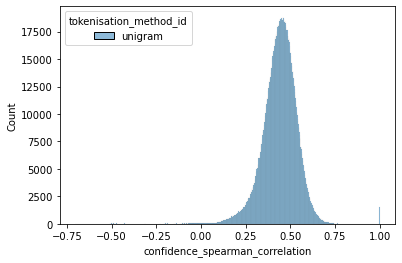

In [214]:
seaborn.histplot(data=distances, x=CORR_TO_USE, hue='tokenisation_method_id')

In [215]:
distances.sample(3)

,language1,language2,confidence_spearman_correlation,tokenisation_method_id
1428676,nre,nhr,0.407973,unigram
1829702,bov,kjb,0.430566,unigram
2231389,gor,sat,0.495779,unigram


In [218]:
%%time
look_up_corr_score = distances.set_index(['language1', 'language2'])[CORR_TO_USE].to_dict()

CPU times: user 3.36 s, sys: 500 ms, total: 3.86 s
Wall time: 3.88 s


In [219]:
def neighbours(language1, recursion=1, nearby_count=5, except_for=[]):
    #extra_constraint = (~distances.language2.isin(except_for))
    extra_constraint = ~distances.language2.isin([])
    one_step = distances[(distances.language1 == language1) &
                          extra_constraint &
                         (distances.language2 != language1)
                        ].nlargest(nearby_count, CORR_TO_USE).language2
    answer = [(language1, x, look_up_corr_score[(language1, x)]) for x in one_step]
    if recursion == 1:
        return answer
    known_so_far = set(one_step)
    known_so_far.update([language1])
    for n in one_step:
        answer += neighbours(n, recursion-1, nearby_count//2 if nearby_count > 3 else 2, except_for=known_so_far)
    return answer

In [220]:
import jinja2
html_page = jinja2.Template("""<!DOCTYPE html>
<html>
  <head>
    <title>{{official_name}}</title>
    <script type="text/javascript" src="https://d3js.org/d3.v4.min.js"></script>
    <script type="text/javascript">var JSON_FILE="{{json_file}}";</script>
    <link type="text/css" rel="stylesheet" href="force.css"/>
  </head>
  <body>
    <svg width="960" height="600"
    xmlns="http://www.w3.org/2000/svg"
    xmlns:xlink="http://www.w3.org/1999/xlink"></svg>
    <script type="text/javascript" src="force.js"></script>
  </body>
</html>
""")

In [221]:
os.makedirs("dynamic_files", exist_ok=True)

def array2color(arr):
    r = int(255 * arr[0])
    g = int(255 * arr[1])
    b = int(255 * arr[2])
    return "#%02x%02x%02x" % (r,g,b)

iterator = tqdm.tqdm(distances.language1.unique())
for language in iterator:
    iterator.set_description(language)
    z = networkx.Graph()
    for (l1, l2, weight) in neighbours(language, recursion=3, nearby_count=8):
        z.add_edge(l1, l2, weight=10 ** weight, title=f"Highest correlation seen between {l1} and {l2} is {weight}")
        nodelist = z.nodes()
    nodesizes = [1000 if n == language else 200 for n in nodelist]
    centrality = pandas.Series(networkx.eigenvector_centrality(z, max_iter=5000))
    how_central = (centrality / centrality.max()).to_dict()
    nodecolors = numpy.array([(1.0,0.6,0.1) if n == language 
                              else 
                              (0.4, how_central[n], 0.8)
                               for n in nodelist])
    node_size_lookup = {n: s for (n,s) in zip(nodelist, nodesizes)}
    node_colour_lookup = {n: array2color(c) for (n,c) in zip(nodelist, nodecolors)}
    for n in z:
        z.nodes[n]["name"] = language_name_lookup.get(n,n)
        z.nodes[n]["color"] = node_colour_lookup[n]
        z.nodes[n]["size"] = node_size_lookup[n]
    with open(f"dynamic_files/{language}.json", 'w') as f:
        json.dump(networkx.readwrite.json_graph.node_link_data(z), f, indent=4, sort_keys=True)

nut: 100%|████████████████████████████████| 1497/1497 [5:56:02<00:00, 14.27s/it]


In [205]:
iterator = tqdm.tqdm(distances.language1.unique())
for language in iterator:
    with open(f"dynamic_files/{language}.html", 'w') as f:
        f.write(html_page.render({ "official_name": language,
                     "json_file": f'{language}.json'}))

100%|█████████████████████████████████████| 1504/1504 [00:00<00:00, 8729.84it/s]


In [228]:
index_template = jinja2.Template("""<!doctype html>
<html lang="en">
<HEAD>
<TITLE>Language Explorer</TITLE>
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.1.1/dist/css/bootstrap.min.css" rel="stylesheet" integrity="sha384-F3w7mX95PdgyTmZZMECAngseQB83DfGTowi0iMjiWaeVhAn4FJkqJByhZMI3AhiU" crossorigin="anonymous">
<meta name="viewport" content="width=device-width, initial-scale=1">
</HEAD>
<BODY>
<div class="container">
    <header class="d-flex flex-wrap justify-content-center py-3 mb-4 border-bottom">
      <a href="/" class="d-flex align-items-center mb-3 mb-md-0 me-md-auto text-dark text-decoration-none">
        <svg class="bi me-2" width="40" height="32"><use xlink:href="#bootstrap"></use></svg>
        <span class="fs-4">LEAFTOP Language Explorer</span>
      </a>
    </header>
  </div>
<main class="bd-content order-1 py-5" id="content">
<h1 class="bd-title mt-0">What is this?</h1>
<p>
You are looking at the first draft of an idea Greg Baker had as he was creating the LEAFTOP dataset.
The LEAFTOP data set is an automatically extracted set of around 300 nouns that can be derived from bible
translations automatically. (The real number is actually higher than this, but this is all that Greg's code
can do at the moment.) For each extracted noun, it is possible to calculate a confidence score -- how
much more likely this word is to be a good translation than the next nearest possibility.
</p>
<p>
Taking that a bit further, we can then do a Spearman correlation on the confidence scores between two 
languages. Very similar languages will pose similar problems for translators (or be similarly easy on 
some words and concepts) so languages that are similar should have high Spearman correlation scores.
Languages that are highly dissimilar should have low Spearman correlation scores.
</p>
<p>
Since it is really boring just looking at correlation scores, Greg decided to make an interactive
explorer. Each language is connected to the 8 languages with which it has the highest correlation.
Those 8 are then connected to the 4 that they are most correlated with, and then each of those gets 2.
But since these aren't exclusive, a tight bundle of languages can occur with not many languages.
</p>
<h2>What can I do with it?</h2>
<p>
You can waste time while you are supposed to working on your linguistics PhD. You can try to
disprove the nostratic hypothesis by finding links between Quechuan and Russian. You can see if this
data matches up with your latest theory about connections between African languages. You can suggest
feature improvements to Greg (gregory.baker2 is the username, and the domain is <tt>hdr.mq.edu.au</tt>).
You can cite this as part of your research so that we can make this explorer respectable enough to become
something you give to your undergraduate students.
</p>
<h2>But this is obviously wrong! Everyone knows that language X and language Y aren't related</h2>
<p>
No doubt this will happen, particularly where language X is in a country that was first evangelised
by speakers of language Y because a data set of nouns from the bible is going to have a lot of loan
words from language Y for precisely the specific vocabulary that is in the bible that wasn't previously
in language X. This will skew X and Y together very strongly.
</p>
<p>
But the fun thing to observe is how often it is <i>right</i> even though this
program has not been trained on any data other than bible translations. There's no model here that
was given a family tree of Indo-European languages: it has just figured these relationships out itself.
</p>

<h2>I'm convinced. I want to play with it now</h2>
<p>
Pick a language from this list below. On the following page you can drag languages around or click on them.
Have fun!
</p>

<UL>
{% for language in languages %}
<LI> <a href="{{language.link}}">{{language.official_name}}</a> </LI>
{% endfor %}
</UL>
</main>
<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.1.1/dist/js/bootstrap.bundle.min.js" integrity="sha384-/bQdsTh/da6pkI1MST/rWKFNjaCP5gBSY4sEBT38Q/9RBh9AH40zEOg7Hlq2THRZ" crossorigin="anonymous"></script>

</BODY>
</HEAD>
</HTML>""")
language_list = pandas.DataFrame({'iso_code': s})

with open("dynamic_files/index.html", "w") as f:
    f.write(index_template.render({"languages": [ {'link': s + ".html", "official_name": language_name_lookup.get(s,s)} for 
                                s in distances.language1.unique()]
                      }))

In [197]:
neighbours('eng', recursion=2, nearby_count=7)

[('eng', 'spa', 0.8849110267002417),
 ('eng', 'por_pt', 0.8733196903437987),
 ('eng', 'ita', 0.869791399382965),
 ('eng', 'fra', 0.8687220541397171),
 ('eng', 'por', 0.8659536870779138),
 ('eng', 'lzh', 0.8625264344119388),
 ('eng', 'hil', 0.8582612198380382),
 ('spa', 'spa_es', 0.9986647053726339),
 ('spa', 'por_pt', 0.9134349710366844),
 ('spa', 'por', 0.9053317581310819),
 ('por_pt', 'por', 0.9698838315957667),
 ('por_pt', 'spa', 0.9134349710366847),
 ('por_pt', 'fra', 0.8862836321499629),
 ('ita', 'por', 0.8865163318682352),
 ('ita', 'fra', 0.8844360899280804),
 ('ita', 'eng', 0.869791399382965),
 ('fra', 'por', 0.898288867518548),
 ('fra', 'por_pt', 0.8862836321499635),
 ('fra', 'ita', 0.8844360899280804),
 ('por', 'por_pt', 0.9698838315957669),
 ('por', 'spa', 0.9053317581310819),
 ('por', 'fra', 0.8982888675185474),
 ('lzh', 'khm', 1.0),
 ('lzh', 'zho_tw', 1.0),
 ('lzh', 'kxz', 0.999551081755334),
 ('hil', 'jpn', 0.878230773038548),
 ('hil', 'tgl', 0.8653359438308327),
 ('hil', 

In [176]:
neighbours('aak', recursion=2, nearby_count=5)

[('aak', 'enx', 0.5560258818415591),
 ('aak', 'lzh', 0.554731935165787),
 ('aak', 'mau', 0.5480464006005851),
 ('aak', 'snc', 0.5393871600260184),
 ('aak', 'niy', 0.5334603971129647),
 ('enx', 'viv', 0.6797039050487006),
 ('enx', 'war', 0.6785469693925654),
 ('enx', 'mbt', 0.6753502042606672),
 ('enx', 'spa_es', 0.6716956887696952),
 ('enx', 'tuv', 0.6639791425183936),
 ('lzh', 'khm', 1.0),
 ('lzh', 'zho_tw', 1.0),
 ('lzh', 'kxz', 0.999551081755334),
 ('lzh', 'kjs', 0.9969012878266019),
 ('lzh', 'guz', 0.9940755232678529),
 ('mau', 'ktu', 0.6633308415224259),
 ('mau', 'czt', 0.6415537082416648),
 ('mau', 'maa', 0.6352984370016546),
 ('mau', 'jpn', 0.6270398261064063),
 ('mau', 'mzh', 0.6238928697405985),
 ('snc', 'khz', 0.7976135310196648),
 ('snc', 'mti', 0.7353260817427177),
 ('snc', 'erg', 0.7143188666614481),
 ('snc', 'nwi', 0.7076602825461248),
 ('snc', 'eri', 0.706166780781963),
 ('niy', 'nuq', 0.7166488960211121),
 ('niy', 'tml', 0.6990789004154034),
 ('niy', 'spa', 0.6919068211

In [153]:
graph['spa']['por_pt']

{'weight': 8.19284938593291}

# Global Centrality

In [229]:
%%time
graph = networkx.Graph()
for l1, l2, v in zip(distances.language1, distances.language2, distances[CORR_TO_USE]):
    if l1 <= l2:
        continue
    if numpy.isnan(v):
        continue
    weight = 10 ** v
    distance = 10 ** (-v)
    graph.add_edge(l1, l2, weight=weight, distance=distance)

CPU times: user 3.28 s, sys: 598 ms, total: 3.87 s
Wall time: 4.78 s


In [232]:
%%time
centres = pandas.Series(networkx.eigenvector_centrality(graph, weight='weight', max_iter=1000))
centres.sort_values()

CPU times: user 10.2 s, sys: 16.5 ms, total: 10.2 s
Wall time: 10.2 s


shn    0.003109
nod    0.005352
bod    0.008630
zho    0.010401
tha    0.012327
         ...   
deu    0.033916
swh    0.034308
fra    0.034421
por    0.034673
spa    0.035012
Length: 1497, dtype: float64

In [231]:
centres.nlargest(20)

spa       0.035012
por       0.034673
fra       0.034421
swh       0.034308
deu       0.033916
hil       0.033741
ell       0.033463
suk       0.033268
por_pt    0.033257
eng       0.033136
spa_es    0.033114
nld       0.033105
tum       0.032992
bxk       0.032924
kik       0.032855
grc       0.032823
ebu       0.032802
kam       0.032627
srp       0.032555
ita       0.032500
dtype: float64

In [109]:
distances[(distances.log_confidence_correlation == 1) &
         (distances.language1 != distances.language2)]

,language1,language2,tokenisation_method_id,confidence_correlation,log_confidence_correlation,confidence_spearman_correlation
102343,aon,ape,unigram,1.0,1.0,1.00000
106852,ape,aon,unigram,1.0,1.0,1.00000
903155,khm,lzh,unigram,1.0,1.0,0.54037
934614,kma,kmy,unigram,1.0,1.0,1.00000
948141,kmy,kma,unigram,1.0,1.0,1.00000
1136120,lzh,khm,unigram,1.0,1.0,0.54037
1136999,lzh,zho_tw,unigram,1.0,1.0,1.00000
2225171,zho_tw,lzh,unigram,1.0,1.0,1.00000


# UMAP

In [ ]:
# I'm not sure if this is helpful or useful any more. It's a partitioned graph now; each tokenisation
# method ends up separate.
algo_fail_languages = ['nod', 'tha', 'khm', 'lzh']

In [110]:
%%time
lcc_square = distances[distances.tokenisation_method_id == 'unigram'].pivot_table(
                index='language1', columns='language2', values='log_confidence_correlation'
                                  ).apply(lambda x: 10**x)
lcc_square.sample(5)

CPU times: user 1.16 s, sys: 256 ms, total: 1.42 s
Wall time: 1.43 s


language2,aai,aak,aau,aaz,abn,abp,abs,abt,abx,aby,...,zpu,zpv,zpz,zrs,zsr,ztq,zty,zul,zyb,zyp
language1,,,,,,,,,,,,,,,,,,,,,
suc,3.191070,2.565196,3.530592,2.802384,3.813672,4.278403,3.080067,3.035675,3.667756,2.369942,...,2.484901,3.061091,2.735724,2.503435,2.939298,2.969868,2.626312,2.326941,4.077458,3.691225
dww,2.913529,2.857280,2.872194,2.253013,2.872882,2.888626,2.324228,2.744174,2.553367,2.325520,...,2.172608,3.088412,2.641811,2.144960,2.098090,2.804382,2.130477,2.600070,2.411811,2.850061
okr,3.429769,2.732256,3.792087,3.223027,3.631194,3.650869,3.375398,2.819762,3.720763,2.566084,...,2.045437,2.755578,2.911435,2.524998,3.151180,3.199251,2.765972,2.956088,3.497414,4.004518
kwj,3.275730,2.809444,3.765629,3.460369,3.395112,3.497641,2.934830,3.451041,3.130614,2.753456,...,2.038845,3.137661,2.359086,2.315173,3.446081,2.994946,2.600350,2.761526,3.263855,4.231505
njb,3.522748,2.974519,3.635821,2.517764,3.354466,3.235671,2.847274,2.538031,2.909487,2.376035,...,2.387535,2.857740,2.621212,2.050879,2.566824,3.310543,2.689267,2.435650,3.410656,3.754654


In [111]:

ok_languages = [x for x in lcc_square.columns if x not in algo_fail_languages]
lcc_square = lcc_square[lcc_square.index.isin(ok_languages)][ok_languages]

In [112]:
%%time
problems = []
for l1 in lcc_square.index:
    for l2 in lcc_square.columns:
        if numpy.isnan(lcc_square.loc[l1,l2]):
            problems.append({'language1': l1, 'language2': l2})
problems = pandas.DataFrame.from_records(problems)
problems

CPU times: user 14.4 s, sys: 11.5 ms, total: 14.4 s
Wall time: 14.4 s


""


In [113]:
lcc_square.isnull().any().any()

False

In [132]:
reducer = umap.UMAP(metric='precomputed', min_dist=0.00001, spread=1)
positions = reducer.fit_transform(lcc_square)

/Users/gregb/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [133]:
positions

array([[4.6953297, 8.9290085],
       [4.6069336, 7.3606315],
       [1.5075219, 6.89601  ],
       ...,
       [2.9246387, 8.328711 ],
       [2.7667935, 8.095144 ],
       [2.5014267, 8.136664 ]], dtype=float32)

<AxesSubplot:xlabel='x', ylabel='y'>

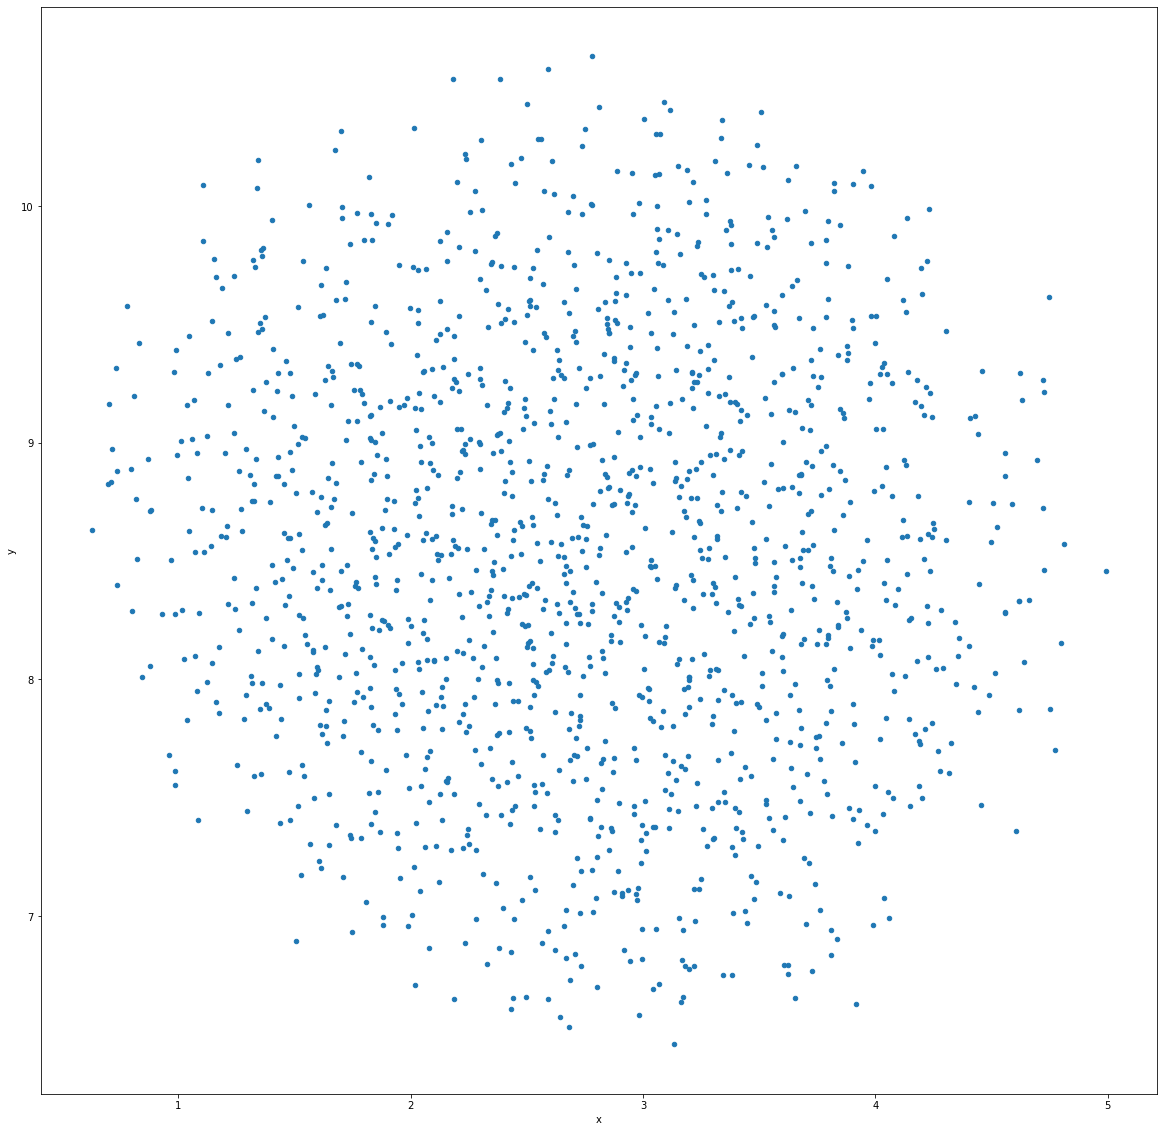

In [134]:
positions_frame = pandas.DataFrame(data=positions, columns=['x', 'y'])
positions_frame.plot.scatter(x='x', y='y', figsize=(20,20))

In [6]:
distances.sample(5)

,language1,language2,tokenisation_method_id,confidence_correlation,log_confidence_correlation,confidence_spearman_correlation
226110,bhw,idu,unigram,0.353656,0.452406,0.437539
523509,duo,bbk,unigram,0.456196,0.432734,0.398663
1771433,set,ssg,unigram,0.362236,0.360237,0.433989
516623,dso,lus,unigram,0.315704,0.410311,0.389037
1499321,nre,tum,unigram,0.613991,0.595503,0.484173


<AxesSubplot:ylabel='Frequency'>

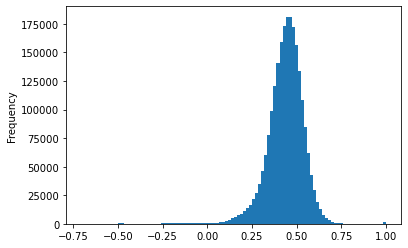

In [10]:
distances.confidence_spearman_correlation.plot.hist(bins=100)

In [12]:
distances.describe()

,confidence_correlation,log_confidence_correlation,confidence_spearman_correlation
count,2.250036e+06,2.250036e+06,2.262016e+06
mean,4.097199e-01,4.398263e-01,4.354088e-01
std,1.210604e-01,9.976508e-02,1.075134e-01
min,-2.317645e-01,-2.877859e-01,-7.034683e-01
25%,3.279929e-01,3.792591e-01,3.845476e-01
50%,4.090599e-01,4.432296e-01,4.449689e-01
75%,4.922048e-01,5.055188e-01,5.002335e-01
max,1.000000e+00,1.000000e+00,1.000000e+00


In [12]:
def correlation_stats(language):
    cache_file = f".cache/{language}.csv"
    if os.path.exists(cache_file):
        return pandas.read_csv(cache_file, index_col='language')
    os.makedirs(".cache", exist_ok=True)
    stats_cursor.execute("""
    select b2.language, 
           max(confidence_correlation), 
           max(log_confidence_correlation), 
           max(confidence_spearman_correlation) 
      from vocabulary_extraction_correlations join bible_versions as b1 on (bible_version_id1 = b1.version_id) 
                                              join bible_versions as b2 on (bible_version_id2 = b2.version_id)
     where b1.language = %s
       and tokenisation_method_id = 'unigram'
  group by b2.language""", [language])
    answer = pandas.DataFrame.from_records([
        {'language': row[0], 'confidence_correlation': row[1], 'log_confidence_correlation': row[2],
        'confidence_spearman_correlation': row[3]}
        for row in stats_cursor
    ])
    answer.to_csv(cache_file, index=False)
    answer.set_index('language', inplace=True)
    return answer

In [13]:
%%time
correlation_stats('spa')

DiskFull: could not write to file "base/pgsql_tmp/pgsql_tmp80521.18": No space left on device


In [ ]:
%%time
correlation_stats('fra')

In [ ]:
read_cursor.execute("""
  select distinct language from bible_versions where version_worth_fetching
  """)
languages = [x[0] for x in read_cursor]
for language in tqdm.tqdm(languages):
    correlation_stats(language)

In [ ]:
graph = networkx.Graph()
for language in tqdm.tqdm(languages):
    df = correlation_stats(language)
    for other_language, corr_value in zip(df.language, df.log_confidence_correlation):
        graph.add_edge(language, other_language, weight=corr_value)

In [ ]:
%%time
centrality = pandas.Series(networkx.eigenvector_centrality_numpy(graph, weight='weight')).sort_values()
centrality

In [ ]:
pandas.Series({x: graph['swe'][x]['weight'] for x in graph['swe']}).sort_values().head(10)

In [16]:
import jinja2
html_page = jinja2.Template("""<!DOCTYPE html>
<html>
  <head>
    <title>{{official_name}}</title>
    <script type="text/javascript" src="https://d3js.org/d3.v4.min.js"></script>
    <script type="text/javascript">var JSON_FILE="{{json_file}}";</script>
    <link type="text/css" rel="stylesheet" href="force.css"/>
  </head>
  <body>
    <svg width="960" height="600"
    xmlns="http://www.w3.org/2000/svg"
    xmlns:xlink="http://www.w3.org/1999/xlink"></svg>
    <script type="text/javascript" src="force.js"></script>
  </body>
</html>
""")



In [25]:
def extend_graph(graph, out_from_node):
    existing_languages = list(graph)
    avoid_terms = ", ".join("%s" * len(existing_languages))
    avoid_clause = f" and language not in ({avoid_terms})"
    if len(existing_languages) == 0:
        avoid_clause = ''
    sql = """
select language, max(mann_whitney_pvalue) as max_mann_whitney_pvalue
from vocabulary_pairing_tests join bible_versions on (bible_version_id2 = version_id)
where bible_version_id1 = %s """ + avoid_clause + """
group by language
order by max_mann_whitney_pvalue desc limit 5
"""
    print(sql)
    read_cursor.execute(sql, [out_from_node] + existing_languages)
    added_languages = []
    for language, pvalue in read_cursor:
        graph.add_edge(out_from_node, language, weight=  )
        added_languages.append(language)
    return added_languages

In [26]:
conn.rollback()

In [27]:
g1 = networkx.Graph()
extend_graph(g1, 'eng')


select language, max(mann_whitney_pvalue) as max_mann_whitney_pvalue
from vocabulary_pairing_tests join bible_versions on (bible_version_id2 = version_id)
where bible_version_id1 = %s 
group by language
order by max_mann_whitney_pvalue desc limit 5



InvalidTextRepresentation: invalid input syntax for type integer: "eng"
LINE 4: where bible_version_id1 = 'eng' 
                                  ^


In [6]:
def make_local_graph(bible_version_id):
    read_cursor.execute("select language from bible_versions where version_id = %s", [bible_version_id])
    language = read_cursor.fetchone()
    if language is None:
        raise ValueError(bible_version_id)
    graph = networkx.Graph()
    read_cursor.execute(
    """)
    languages_seen = set([language])
    version_ids_to_extend = []
    # One stage out languages
    for (other_language, version_id, pvalue) in read_cursor:
        
        languages_seen.update([other_language])
        version_ids_to_extend.update([(other_language, version_id)])
    # Two stages out:
    for extended_language, extended_version_id in version_ids_to_extend:
        
    read_cursor.execute("""select version_name, bible_version_id2, mann_whitney_pvalue 
from vocabulary_pairing_tests join bible_versions on (bible_version_id2 = version_id)
where bible_version_id1 = %s and language = %s and bible_version_id2 != bible_version_id1
    """)
    for (name, version_id, pvalue) in read_cursor:
        graph.add_edge(f"{language}-{bible_version_id}", f"{language}-{version_id}", 
                       weight= 1/(1+math.log10(1/pvalue)) )
    return graph

In [17]:
def array2color(arr):
    r = int(255 * arr[0])
    g = int(255 * arr[1])
    b = int(255 * arr[2])
    return "#%02x%02x%02x" % (r,g,b)

def networkx_visualise_to_d3(s, filesystem_prefix=""):
    global graph
    #g = graph.subgraph(close_neighbours[s]).copy()
    g = networkx.generators.ego.ego_graph(graph, s, 4).copy()
    nodelist = list(g)
    nodesizes = [1000 if n == s else 200 for n in nodelist]
    centrality = pandas.Series(networkx.eigenvector_centrality(g, max_iter=5000))
    how_central = (centrality / centrality.max()).to_dict()
    #print(how_central)
    nodecolors = numpy.array([(1.0,0.6,0.1) if n == s 
                              else 
                              (0.4, how_central[n], 0.8)
                               for n in nodelist])
    #print(nodecolors)
    #print(seen_before)
    #networkx.drawing.nx_pydot.write_dot(z, s + ".dot")
    node_size_lookup = {n: s for (n,s) in zip(nodelist, nodesizes)}
    node_colour_lookup = {n: array2color(c) for (n,c) in zip(nodelist, nodecolors)}

    d1,d2 = networkx.algorithms.shortest_paths.weighted.dijkstra_predecessor_and_distance(g, s, 
                                                                                      weight='distance')
    most_interesting_nodes = set(pandas.Series(d2).nsmallest(25).index)
    #most_interesting_nodes = set(centrality.nlargest(30).index)
    most_interesting_nodes.update([s])
    z = g.subgraph(most_interesting_nodes).copy()
    for n in z:
        z.nodes[n]["name"] = game_names_simplified[n]
        z.nodes[n]["color"] = node_colour_lookup.get(n, (0.3, 0.3, 0.3))
        z.nodes[n]["size"] = node_size_lookup.get(n, 10)
        
    json_file_on_disk = os.path.join(filesystem_prefix, s + ".json")
    with open(json_file_on_disk, 'w') as f:
        json.dump(networkx.readwrite.json_graph.node_link_data(z), f, indent=4, sort_keys=True)
    html_file_on_disk = os.path.join(filesystem_prefix, s + ".html")
    with open(html_file_on_disk, 'w') as f:
        f.write(html_page.render({ "official_name": game_names_simplified[s],
                     "json_file": s + '.json'}))
    return g

In [18]:
iterator = tqdm.tqdm(game_names_simplified.items())
for game, full_name in iterator:
    iterator.set_description(full_name)
    networkx_visualise_to_d3(game, filesystem_prefix="dynamic_files")

KEPLERTH: 100%|███████████████████████████████| 5632/5632 [09:57<00:00,  9.43it/s]
